In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.special import erfc, erfcinv

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


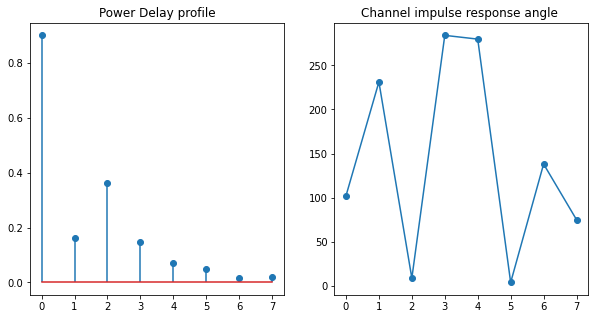

In [2]:
ser = 10**(-5) #Symbol error rate we want to achieve




mat = scipy.io.loadmat('CIR.mat')
mat['h'].shape
CIR = mat['h']
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.stem(np.abs(CIR))

plt.title("Power Delay profile")

plt.subplot(122)
plt.title("Channel impulse response angle ")
plt.plot(((180/np.pi) * np.angle(CIR))%360, '-o')
plt.show()



(8, 1)
(128, 1)


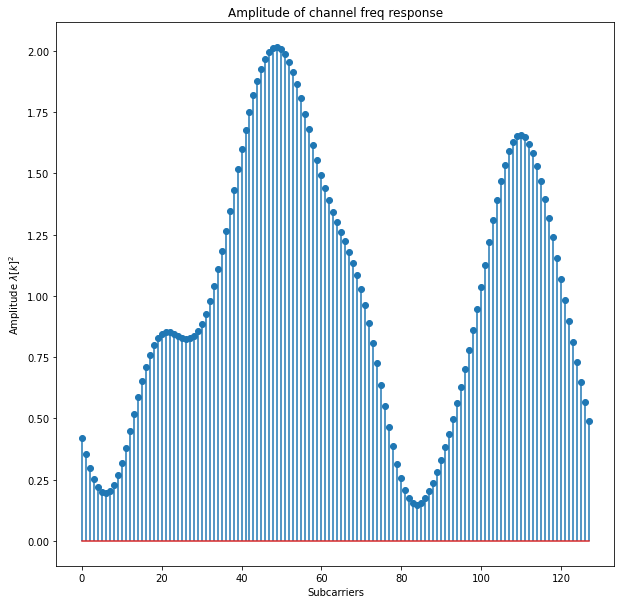

In [6]:
print(CIR.shape)
freqres = np.fft.fft(CIR,n=128, axis=0)
print(freqres.shape)
plt.figure(figsize = (10,10))
plt.stem(np.abs(freqres[:,:])**2)
plt.title("Amplitude of channel freq response")
plt.xlabel("Subcarriers")
plt.ylabel("Amplitude $\lambda [k]^2$")
plt.show()

Establish the general procedure for maximizing the available bit rate
by optimizing the allocated powers p k and the number of bits b k for a given channel impulse response (and hence frequency response) and
based on the constraints described above. In order to simplify the
procedure, it is assumed that b k is real and is not restricted to an
integer.

Implement this optimization procedure for the particular realization
of the channel impulse response provided to you for 3 different values
E s /N 0 = 0, 10 and 20 dB, and evaluate the gain (in terms of bit rate)
with respect to uniform power allocation and/or uniform bit allocation.



In [4]:
pe = ser
SNRGap = (2/3)*(erfcinv(pe/2))**2
SNRGapdb = 10*np.log10(SNRGap)
print("SNR gap is {:.2f}, which dives {:.2f} dB".format(SNRGap, SNRGapdb))

SNR gap is 6.95, which dives 8.42 dB


array([[ 0.15898139+0.62811469j],
       [ 0.12995987+0.58170063j],
       [ 0.09410606+0.53883192j],
       [ 0.05173272+0.50082697j],
       [ 0.0034967 +0.46902489j],
       [-0.04958002+0.44467773j],
       [-0.10612535+0.42883598j],
       [-0.16446953+0.42223945j],
       [-0.22273211+0.42522568j],
       [-0.27893684+0.43766679j],
       [-0.33114447+0.45894272j],
       [-0.37759135+0.48795553j],
       [-0.41682073+0.52318527j],
       [-0.44779395+0.56278349j],
       [-0.46997086+0.604697j  ],
       [-0.48335114+0.64681107j],
       [-0.48847254+0.6870994j ],
       [-0.48636577+0.72376754j],
       [-0.47847019+0.75537698j],
       [-0.46651801+0.7809393j ],
       [-0.45239771+0.7999725j ],
       [-0.43800896+0.8125156j ],
       [-0.42512194+0.81910154j],
       [-0.41525301+0.82069228j],
       [-0.40956668+0.81858347j],
       [-0.408811  +0.81428851j],
       [-0.41328967+0.80941332j],
       [-0.42287101+0.80553318j],
       [-0.43702977+0.80408223j],
       [-0.454

# Old implementations

In [ ]:
esnodb = 20
esno = 10**(-esnodb/10)
sigsq = 1/(128*esno)
power = sigsq * SNRGap



@interact
def splot(level=(0, 3, 0.001)):
    
    pk = sigsq/freqres


    plt.stem(np.abs(pk))
    plt.stem(np.ones(128)*level)
    
    pk[np.abs(pk)<level] = 0
    power = np.sum(np.abs(pk))
    plt.title("Power above threshold: {:.2f}".format(power))
    return power






In [ ]:
def evaluate(level, sigmasquare):
    
    pk = sigmasquare/freqres    
    pk[np.abs(pk)<level] = 0
    power = np.sum(np.abs(pk))
    return power


def find_min_level(low,high,step, esnodb, powermax):
    
    sigsq = 1/(128*10**(-esnodb/10))
    
    
    tests = np.arange(low,high,step)
    minlev = 1000
    for i in tests:
        power = evaluate(i,sigsq)
        if(power<powermax and i<minlev):
            minlev = i
    if(minlev == 1000): print("Evaluate: Out of bound")
    return minlev

find_min_level(0.0,5,0.001, 20,1)




In [ ]:
listdb = [0,10,20]

plt.figure(figsize = (20,20))
for i,j in enumerate(listdb):
    
    level = find_min_level(0.0,5,0.001, j,1)

    #vector = (1/2)* np.log2(1+   (freqres*power)/(sigsq*power)   )
    
    poweralloc = level - sigsq/freqres
    
    occur  = np.abs(poweralloc)>level #Create mask
    occur = np.sum(occur)
    print(occur)
    
    poweralloc[np.abs(poweralloc)<level]=0
    
    
    
    plt.subplot(221+i)    
    plt.stem(np.abs(poweralloc))
    
    
    
    plt.stem(np.ones(128)*level,linefmt='grey', markerfmt='r')
    
    
    
    plt.title("Water filling with Es/NO = {:.0f} dB".format(j))
    plt.xlabel("Subchannels ({:d} being used)".format(occur))
    #plt.yscale('log')
    plt.legend(['Power allocated', 'Threshold'])
    plt.ylabel("Power")
    
#Lets now do uniform allocation
#Each channel gets same power: p = sigsq *snrgap



## Water filling algo
$P_k = 0 $ si $\Gamma^2>\frac{1}{2\lambda ln(2)}$


$P_k = \frac{1}{2\lambda ln(2)} - \Gamma^2 $ sinon

avec $\Gamma$

In [ ]:
listdb = [0,10,20]

plt.figure(figsize = (20,20))
for i,j in enumerate(listdb):
    esnodb = j
    esno = 10**(-esnodb/10)
    sigsq = 1/(128*esno)
    
    power = sigsq * SNRGap

    #vector = (1/2)* np.log2(1+   (freqres*power)/(sigsq*power)   )
    
    poweralloc = (1/(2*(freqres)*np.log2(2))) - sigsq/freqres
    
    occur  = np.abs(poweralloc)>power #Create mask
    occur = np.sum(occur)
    print(occur)
    
    
    plt.subplot(221+i)    
    plt.stem(np.abs(poweralloc))
    
    
    
    plt.stem(np.ones(128)*power,linefmt='grey', markerfmt='r')
    
    
    
    plt.title("Water filling with Es/NO = {:.0f} dB".format(j))
    plt.xlabel("Subchannels ({:d} being used)".format(occur))
    #plt.yscale('log')
    plt.legend(['Power allocated', 'Threshold'])
    plt.ylabel("Power")
    
#Lets now do uniform allocation
#Each channel gets same power: p = sigsq *snrgap



 ## Computing data throughput
  - Plot BER/SNR for each type of constellation
  - View SNR on each channel and choose right constellation
  - Sum all bits (constellations) on all channels
  
 PAS du tout, juste prendre les formules de louis et mettre les bon pk